In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 프로젝트명 : 나랑 닮은 연예인은 누구? 

비교 대상의 이미지가 얼마나 닮았는 지 알아보는 문제는 두 얼굴 벡터 사이의 거리가 얼마나 되나 하는 문제로 치환된다.  
임베딩 : 고차원 정보를 저차원으로 변환하면서 필요한 정보를 보존하는 것

## 1. 데이터 준비

In [2]:
!pip install face_recognition

주변 사람들에게 닮았다고 얘기 들어본 적이 있는 유명인들의 사진과 내 이미지를 불러온다.

file_list: ['박상영.jpg', '김종국.jpg', '이준.jpg', '정겨운.jpg', '강형욱.jpg', '김경현1.jpg', '김경현2.jpg', '임영웅.jpg']


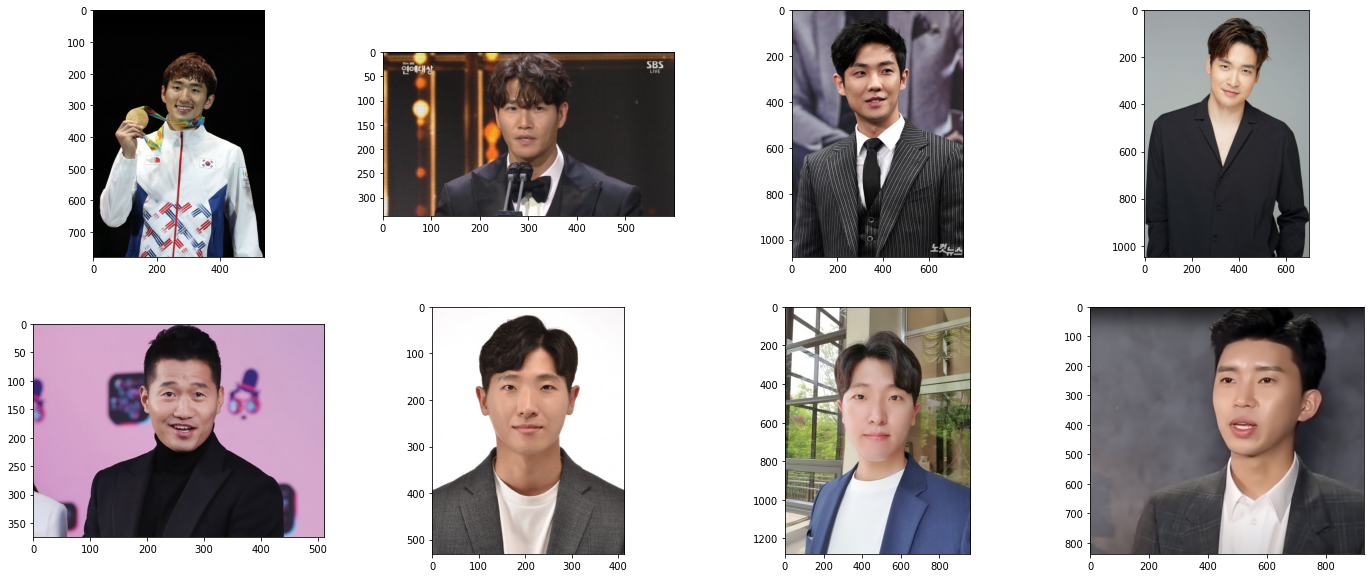

In [3]:
import face_recognition
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
from PIL import Image
import numpy as np

dir_path = '/content/gdrive/MyDrive/Aiffel/EXP/E05/images'
file_list = os.listdir(dir_path)
print("file_list: {}".format(file_list))  # file_list 출력

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
  image = img.imread(dir_path+'/'+file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

## 2. 얼굴 인식
- __def get_cropped_face(image_file):__ 이미지 파일에서 얼굴 영역을 가져오는 함수
- 이미지 속의 두 얼굴이 얼마나 닮았는지 알아보기 위해 얼굴 임베딩을 구하기에 앞서 얼굴 영역만을 정확하게 인식해서 추출하는 작업을 먼저 진행한다.

### 2-1.데이터 샘플 테스트
얼굴 영역을 인식해서 추출하는 작업을 진행하기 위해 우선 내 사진 1장을 샘플로 불러와본다.

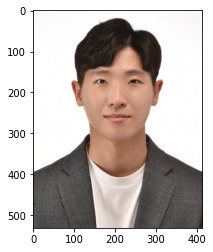

In [4]:
image_path = '/content/gdrive/MyDrive/Aiffel/EXP/E05/images/김경현1.jpg'
img_bgr = cv2.imread(image_path)  # OpenCV로 이미지 읽기
img_show = img_bgr.copy()  # 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

얼굴 영역 인식이 제대로 됐는지 이미지를 불러와본다.

[(118, 304, 304, 118)]


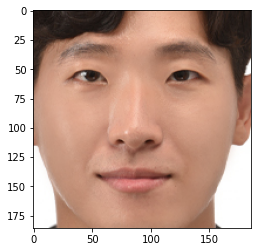

In [5]:
image = face_recognition.load_image_file(image_path)
face_locations = face_recognition.face_locations(image)

print(face_locations)  # 이미지에서 얼굴 영역의 좌표를 출력합니다.

a, b, c, d = face_locations[0]  # a, b, c, d = [(top, right, bottom, left)]
cropped_face = image[a:c,d:b,:]  # (a:c, d:b) = (top:bottom, left:right)

plt.imshow(cropped_face)   # 이미지에서 얼굴영역만 잘라낸 cropped_face를 그려 봅니다.

### 2-2. 얼굴 영역 인식 함수 생성
- 위와 같이 다른 이미지들도 얼굴 영역을 인식하기 위해 함수를 만들어 줍니다.

In [6]:
# cropped_face 함수 만들기

def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

1. 이미지 경로 :/content/gdrive/MyDrive/Aiffel/EXP/E05/images/김경현2.jpg
2. face locations :[(118, 304, 304, 118)]


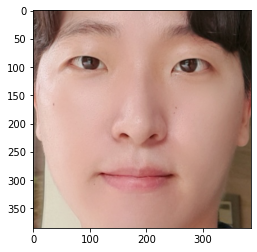

In [7]:
# cropped_face 함수 실행(샘플 이미지를 통해 잘 만들어졌는지 확인해줍니다.)
image_path = '/content/gdrive/MyDrive/Aiffel/EXP/E05/images/김경현2.jpg'
print('1. 이미지 경로 :{}'.format(image_path))

cropped_face = get_cropped_face(image_path)
print('2. face locations :{}'.format(face_locations))  # 이미지에서 얼굴 영역의 좌표를 출력합니다.

plt.imshow(cropped_face)  # cropped_face 이미지 출력

In [8]:
# 인식한 얼굴 영역을 따로 저장하는 함수 만들기
def save_cropped_face(dir_path):
    file_list = os.listdir(dir_path)

    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        pillow_image = Image.fromarray(face)
        path_to_save = os.path.join(save_path, file)
        pillow_image.save(path_to_save)

In [9]:
save_path = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_images'
save_cropped_face(dir_path)

print("cropped images 저장 완료!")

cropped images 저장 완료!


## 3. 얼굴 영역에 대한 임베딩 벡터 구하기
- __def get_face_embedding(face)__ : 얼굴 영역으로부터 얼굴 임베딩 벡터를 구하는 함수
- __def get_face_embedding_dic(dir_path)__ : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수

### 3-1. 임베딩 벡터 구하기

In [10]:
# 임베딩 벡터를 구할 이미지
image_file = os.path.join(dir_path, '김경현1.jpg')
print("이미지 경로: {}".format(image_file))

# 얼굴 영역을 구하는 함수(이전 스텝에서 구현)
face = get_cropped_face(image_file)

이미지 경로: /content/gdrive/MyDrive/Aiffel/EXP/E05/images/김경현1.jpg


In [11]:
# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

# 임베딩 벡터 출력
embedding = get_face_embedding(face)
embedding
print(len(embedding[0]))

128


### 3-2. 임베딩 후 dictionary화 하기

In [12]:
# embedding_dict = get_face_embedding_dict(dir_path):
# embedding_dict['obama']  # obama.jpg의 얼굴임베딩 벡터

In [13]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        
    return embedding_dict

In [14]:
embedding_dict = get_face_embedding_dict(dir_path)  # 임베딩 dict 작업 완료

## 4. 얼굴 임베딩 사이의 거리측정

In [15]:
import numpy as np

In [16]:
# np.linalg.norm
# 두 개의 얼굴 이미지 임베딩 벡터 거리(L2 distance)를 구하는 함수

def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1] - embedding_dict[name2], ord=2)

get_distance('김경현1', '김경현2')

0.3335478699913977

## 5. 가장 닮은 꼴 얼굴 찾아보기

In [17]:
def get_nearest_face(name, top=5):
    pass
get_nearest_face('김경현1')

In [18]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, 
# name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.

def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('김경현1')
# 이렇게 생성된 함수 sort_key_func는 sort_key_func('김경현2') 라고 호출할 때 
# 김경현1과 김경현2 사이의 임베딩 벡터 거리를 계산합니다.

In [19]:
# 이미지 파일에 대한 얼굴 임베딩 딕셔너리를 오름차순 정렬
# 정렬 기준은 김경현1과의 임베딩 벡터 거리 함수
# lambda 함수가 정렬 key로 활용

# sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))

In [20]:
# 입력받은 임의의 이름에 대해 다른 이미지의 임베딩 거리를 정렬해서 출력해주는 함수

def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

In [21]:
# 나와 가장 닮은 사람은 누굴까요?
get_nearest_face('김경현1')

순위 1 : 이름(박상영), 거리(0.30967391149608553)
순위 2 : 이름(김경현2), 거리(0.3335478699913977)
순위 3 : 이름(이준), 거리(0.3392383173796039)
순위 4 : 이름(정겨운), 거리(0.4610800798806975)
순위 5 : 이름(강형욱), 거리(0.4818943281489957)


In [22]:
# 나와 가장 닮은 사람은 누굴까요?
get_nearest_face('김경현2')

순위 1 : 이름(김경현1), 거리(0.3335478699913977)
순위 2 : 이름(박상영), 거리(0.3936978996741507)
순위 3 : 이름(이준), 거리(0.4575150251473906)
순위 4 : 이름(정겨운), 거리(0.46726551216469747)
순위 5 : 이름(임영웅), 거리(0.48421115033843404)


얼마 전 조카가 TV를 보다가 삼촌이 TV에 나온다고 해서 누구를 말하나 했더니 펜싱 국가대표 박상영 선수를 얘기한 것이었다.
그런데 실제로 박상영 선수와 가장 거리가 가깝게 나왔다. 30개월 밖에 안된 어린아이의 눈썰미에 감탄하며 이번에는 좀 더 많은 이미지를 가져와서 닮은 꼴을 찾아보겠다.

## 6. 데이터 추가하기

기존 이미지에 다른 유명인 이미지도 추가하여 새로운 닮은 꼴을 찾아본다.

### 6-1. 새로운 데이터 준비

In [23]:
dir_path = '/content/gdrive/MyDrive/Aiffel/EXP/E05/celebrity'
file_list = os.listdir(dir_path)
print("1. 파일 목록: {}".format(file_list))  # file_list 출력
print("2. 파일 개수: {}".format(len(file_list))) # 파일 개수 확인

1. 파일 목록: ['obama.jpg', 'biden.jpg', 'bush.jpeg', 'clinton.jpeg', 'trump.jpg', '고창석.jpeg', '야마다 타카유키.jpeg', '장동건.jpeg', '최준석.jpg', '이대호.jpeg', '박찬호.jpg', '류현진.jpg', '박용택.jpg', '무라니시.png', '서강준.jpg', '박항서.jpg', '김학범.jpg', '신태용.jpg', '손흥민.jpg', '윤경신.jpg', '차두리.jpeg', '이동국.jpeg', '기성용.jpg', '류승룡.jpeg', '황병국.jpg', '하정우.jpg', '강동원.jpg', '이정재.jpeg', '박보검.jpg', '차범근.jpeg', '배성재.jpg', '배성우.png', '조승우.jpeg', '유해진.jpg', '김윤석.jpeg', '주진모(올드).jpg', '권태원.jpeg', '박성호.jpg', '김상호.png', '김대명.jpeg', '도지한.jpg', '이범수.jpeg', '박서준.jpeg', '김민재.jpeg', '조달환.png', '공유.jpg', '방시혁.jpeg', '박진영.jpg', '박재범.jpg', '지드래곤.jpeg', '정형돈.jpg', '노홍철.jpeg', '유재석.jpg', '이재용.jpg', '박명수.jpg', '정준하.jpg', '길.jpg', '개리.jpg', '개코.jpeg', '슈퍼비.jpeg', '씨잼.jpg', '스윙스.jpeg',

### 6-2. 얼굴 영역 인식

In [24]:
# cropped_face 함수 만들기
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

In [25]:
# 얼굴영역 crop 후 이미지로 저장하는 함수 만들기
def save_cropped_face(dir_path):
    file_list = os.listdir(dir_path)

    for file in file_list:  # 얼굴영역 인식이 안되는 사진 존재 시 예외처리 진행
        img_path = os.path.join(dir_path, file)
        try:
            face = get_cropped_face(img_path)
            pillow_image = Image.fromarray(face)
            path_to_save = os.path.join(save_path, file)
            pillow_image.save(path_to_save)
        except:
            continue

아까와는 달리 예외처리를 하지 않으면 오류가 발생하였다.  
추가된 이미지 중에 얼굴 영역을 인식하지 못하는 경우가 있는 것으로 추측된다.

In [26]:
# 다음의 디렉토리에 얼굴 영역 이미지를 저장시킨다.
save_path = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity'
save_cropped_face(dir_path)

### 6-3. 얼굴 영역에 대한 임베딩 벡터 구하기

In [27]:
# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

# 임베딩 벡터 출력
embedding = get_face_embedding(face)
embedding

[array([-0.10830995,  0.1197815 ,  0.01222596, -0.09590606, -0.11299239,
        -0.01133827, -0.0585273 , -0.09193641,  0.10710984, -0.09348884,
         0.19311318, -0.07282633, -0.23192045, -0.11284794, -0.07630381,
         0.1989885 , -0.17844833, -0.15386169, -0.05072051, -0.00222726,
         0.13328554,  0.01442116, -0.04210454,  0.03084414, -0.10592915,
        -0.3244434 , -0.09786365, -0.04112839,  0.03149914, -0.0641422 ,
        -0.03855838, -0.00408209, -0.24821961, -0.05372888,  0.02862731,
         0.09277384, -0.01960505, -0.05559578,  0.16246118,  0.04435951,
        -0.20098509,  0.06756418,  0.07633774,  0.21408248,  0.1821146 ,
         0.06032223,  0.04546347, -0.14661713,  0.15799405, -0.15022783,
         0.00837995,  0.20645058,  0.13582882,  0.09674781, -0.02409046,
        -0.10154882,  0.04947025,  0.12171239, -0.1465115 ,  0.03944434,
         0.12220475, -0.05210355, -0.05234563, -0.11305439,  0.22076088,
         0.01272733, -0.15206552, -0.21085955,  0.1

In [28]:
# 얼굴영역 인식이 안되는 사진들에 대한 예외처리가 추가된 함수
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        try:
            face = get_cropped_face(img_path)
        except:
            continue

        embedding = get_face_embedding(face)
        if len(embedding) > 0:
            # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
            # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]

    return embedding_dict

얼굴 영역 인식 역시 기존 코드로는 인식이 안되는 사진들이 있어 새로운 코드를 통해 예외처리를 적용해준다.

In [29]:
embedding_dict = get_face_embedding_dict(dir_path)  # 임베딩 dict 작업 완료

### 6-4. 얼굴 임베딩 사이의 거리 측정

In [30]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

### 6-5. 가장 닮은 꼴 얼굴 찾아보기

In [31]:
# 나와 가장 닮은 사람은 누굴까요?
get_nearest_face('김경현1')

순위 1 : 이름(박상영), 거리(0.30967391149608553)
순위 2 : 이름(김경현2), 거리(0.3335478699913977)
순위 3 : 이름(이준), 거리(0.3392383173796039)
순위 4 : 이름(박건우), 거리(0.3850491510843041)
순위 5 : 이름(이대형), 거리(0.3922371845377091)


In [32]:
# 나와 가장 닮은 사람은 누굴까요?
get_nearest_face('김경현2')

순위 1 : 이름(김경현1), 거리(0.3335478699913977)
순위 2 : 이름(RM), 거리(0.37715163671190033)
순위 3 : 이름(박보영), 거리(0.38026313737162837)
순위 4 : 이름(정국), 거리(0.3808316968408021)
순위 5 : 이름(우기), 거리(0.38843923903050326)


두번째 사진(김경현2)은 서드파티 카메라 앱을 사용했더니 새로운 유명인들이 나왔다.

## 7. 시각화

In [33]:
# 한글폰트 깨짐 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


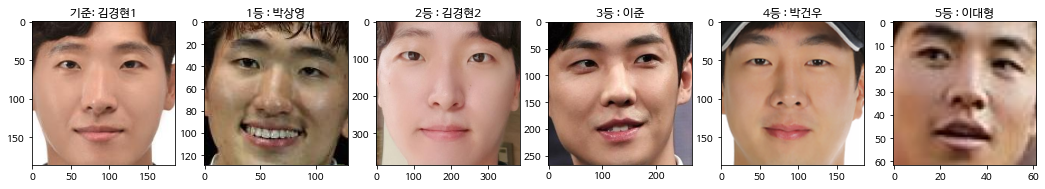

In [39]:
plt.rc('font', family='NanumBarunGothic')  # 나눔바른고딕 폰트 설정

img_path_1 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/김경현1.jpg'
img_path_2 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/김경현2.jpg'
img_path_3 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/박상영.jpg'
img_path_4 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/이준.jpg'
img_path_5 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/박건우.png'
img_path_6 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/이대형.jpg'

f,ax = plt.subplots(nrows=1, ncols=6, figsize=(18,6))

ax[0].imshow(cv2.cvtColor(cv2.imread(img_path_1), cv2.COLOR_BGR2RGB))
ax[0].set_title('기준: 김경현1')
ax[1].imshow(cv2.cvtColor(cv2.imread(img_path_3), cv2.COLOR_BGR2RGB))
ax[1].set_title('1등 : 박상영')
ax[2].imshow(cv2.cvtColor(cv2.imread(img_path_2), cv2.COLOR_BGR2RGB))
ax[2].set_title('2등 : 김경현2')
ax[3].imshow(cv2.cvtColor(cv2.imread(img_path_4), cv2.COLOR_BGR2RGB))
ax[3].set_title('3등 : 이준')
ax[4].imshow(cv2.cvtColor(cv2.imread(img_path_5), cv2.COLOR_BGR2RGB))
ax[4].set_title('4등 : 박건우')
ax[5].imshow(cv2.cvtColor(cv2.imread(img_path_6), cv2.COLOR_BGR2RGB))
ax[5].set_title('5등 : 이대형')

plt.show()

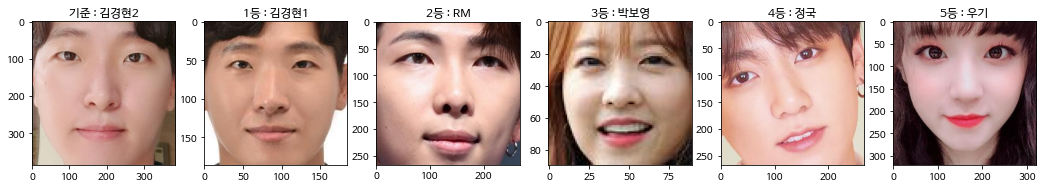

In [40]:
img_path_1 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/김경현1.jpg'
img_path_2 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/김경현2.jpg'
img_path_7 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/RM.jpg'
img_path_8 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/박보영.jpg'
img_path_9 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/정국.jpg'
img_path_10 = '/content/gdrive/MyDrive/Aiffel/EXP/E05/cropped_celebrity/우기.jpg'

f,ax = plt.subplots(nrows=1, ncols=6, figsize=(18,6))

ax[0].imshow(cv2.cvtColor(cv2.imread(img_path_2), cv2.COLOR_BGR2RGB))
ax[0].set_title('기준 : 김경현2')
ax[1].imshow(cv2.cvtColor(cv2.imread(img_path_1), cv2.COLOR_BGR2RGB))
ax[1].set_title('1등 : 김경현1')
ax[2].imshow(cv2.cvtColor(cv2.imread(img_path_7), cv2.COLOR_BGR2RGB))
ax[2].set_title('2등 : RM')
ax[3].imshow(cv2.cvtColor(cv2.imread(img_path_8), cv2.COLOR_BGR2RGB))
ax[3].set_title('3등 : 박보영')
ax[4].imshow(cv2.cvtColor(cv2.imread(img_path_9), cv2.COLOR_BGR2RGB))
ax[4].set_title('4등 : 정국')
ax[5].imshow(cv2.cvtColor(cv2.imread(img_path_10), cv2.COLOR_BGR2RGB))
ax[5].set_title('5등 : 우기')

plt.show()

## 8. 회고

__1. 데이터 예외 처리__ : 처음에는 10장 미만의 사진으로 노드의 코드를 이용해 구현을 했을 때 별다른 오류 없이 실행 되었으나, 사진의 양을 늘려서 실행 했을 때는 얼굴 인식이 안되는 사진이 있어서 오류가 발생하였다. 이러한 경우엔 try/except 예외 처리를 이용해 오류가 발생하면 continue 되게 하였다. 추가적으로 어떤 파일이 오류가 나는지 리스트로 확인하는 방법을 연구해볼 수 있을 것 같다.  
__2. 구글 코랩의 한글 KeyError 현상__ : 특히, 임베딩 벡터들을 딕셔너리에 담는 과정에서 처음 이 현상이 발생하였는데, 오류 메시지에 나와있는 한글 부분을 다시 코드에 복붙 하면 정상적으로 실행이 되었다. 왜 이러한 문제가 발생하는지는 잘 모르겠어서 그냥 넘어 갔는데 아지트에 안형준님이 해당 문제가 발생하는 이유를 글로 올려주셔서 참고 해봐야겠다.  
__3. 닮은 연예인 찾기__ : 앞에서도 잠깐 언급했지만 30개월 된 조카가 닮았다고 인정한 박상영 선수가 닮은 꼴 1위로 나왔다. AI에 버금가는 조카의 천재성을 의심해볼만 하다.  
__4. 시각화__ : FUN, EXP 노드에서 학습했던 Pillow, OpenCV를 활용하여 cropped image를 저장하고 다시 시각화 해보았다. 나와 닮았다고 나오는 top5 이미지만 다시 저장해서 바로 출력되게끔 함수를 구현하고 싶었는데 여러 차례 실패 후 포기 하였다. 그리고 tkinter나 flask를 활용한 시각화는 아직 나의 레벨에서 무리인 것 같다.  
__5. 폰트 깨짐 현상__ : 위의 시각화 과정에서 set_title에 한글 폰트 적용 시 깨짐 현상이 발생하였다. 이 문제를 해결하기 위해 아지트와 구글링으로 폰트 오류 문제를 해결 할 수 있었다.  
__6. 기본으로 돌아가자__ : 결국 기본이 제일 중요한 것 같다. 내가 생각하는, 구현하고 싶은 것들을 코드로 옮기려면 파이썬의 기본 문법이 밑바탕으로 깔려 있어야 가능한 것들이다. 가장 자주 사용하문 def 함수나, for문 같은 경우 독해는 되지만 아직 자유자재로 내가 코드를 구현할만한 실력은 못된다. 이런 부분을 앞으로 계속 보완해 나가야 할 필요가 있다.

## 9. Reference  
- [코딩도장: try, except 사용하기]('https://dojang.io/mod/page/view.php?id=2398')
- [구글 코랩(colab) 한글 깨짐 현상 해결방법]('https://teddylee777.github.io/colab/colab-korean')